<a href="https://colab.research.google.com/github/Emmanuelprz1400/electricity-production-forecasting/blob/main/electricity_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas y funciones

In [ ]:
import numpy as np
import pandas as pd

import itertools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


In [ ]:
def p_value_adfuller(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Se rechaza la hipótesis nula, los datos son estacionarios')
        else:
            print('No se rechaza la hipóteis nula, los datos no son estacionarios')


# Lectura y exploración de la Serie de Tiempo

In [ ]:
file = 'https://raw.githubusercontent.com/Emmanuelprz1400/electricity-production-forecasting/main/Datos/IPG2211A2N%20_2023_01.csv'

datos = pd.read_csv(file,
                    index_col = [0],
                    parse_dates=['DATE']
                    )
datos = datos.loc['2000-01-01':]
datos.columns = ['Producción']  # NAICS 2211

datos

,Producción
DATE,
2000-01-01,100.9623
2000-02-01,93.1065
2000-03-01,87.0234
2000-04-01,80.4433
2000-05-01,83.4549
...,...
2022-09-01,100.4154
2022-10-01,91.0391
2022-11-01,100.8168


## Asegurar el orden y la continuidad de la serie de tiempo

In [ ]:
# La monotonicidad es una propiedad matemática que indica que una función
# determinada mantiene un orden no creciente o decreciente en todo su dominio

datos.index.is_monotonic_increasing

True

In [ ]:
datos.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01'],
              dtype='datetime64[ns]', name='DATE', length=277, freq=None)

In [ ]:
# para algunas funciones de ST es importante indicar la frecuencia de nuestros datos
datos.index.freq = datos.index.inferred_freq
datos.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-03-01', '2000-04-01',
               '2000-05-01', '2000-06-01', '2000-07-01', '2000-08-01',
               '2000-09-01', '2000-10-01',
               ...
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01'],
              dtype='datetime64[ns]', name='DATE', length=277, freq='MS')

Para más información de las frecuencias en pandas consultar el apartado DateOffset objects en [este enlace](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

### Ejemplo de Serie discontinua

In [ ]:
df  = datos.drop( ['2000-03-01', '2015-09-01', '2019-07-01'])
df

,Producción
DATE,
2000-01-01,100.9623
2000-02-01,93.1065
2000-04-01,80.4433
2000-05-01,83.4549
2000-06-01,89.9617
...,...
2022-09-01,100.4154
2022-10-01,91.0391
2022-11-01,100.8168


In [ ]:
df.index.is_monotonic_increasing

True

In [ ]:
# para algunas funciones de ST es importante indicar la frecuencia de nuestros datos
df.index.freq = df.index.inferred_freq
df.index

DatetimeIndex(['2000-01-01', '2000-02-01', '2000-04-01', '2000-05-01',
               '2000-06-01', '2000-07-01', '2000-08-01', '2000-09-01',
               '2000-10-01', '2000-11-01',
               ...
               '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
               '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01',
               '2022-12-01', '2023-01-01'],
              dtype='datetime64[ns]', name='DATE', length=274, freq=None)

In [ ]:
df.index.min(), df.index.max()

(Timestamp('2000-01-01 00:00:00'), Timestamp('2023-01-01 00:00:00'))

In [ ]:
# Creamos una Series de pandas con las fechas esperadas para compararlo con las
# fechas en nuestra serie de tiempo.

obsEsperadas = pd.Series(data=pd.date_range(start=df.index.min(), end=df.index.max(), freq='MS'))

# Filtramos las fechas, en las obserbvaciones Esperadas que no aparecen en
# nuestra serie de tiempo

faltantes = obsEsperadas[~ obsEsperadas.isin(df.index)]

for i in faltantes.dt.strftime('%Y/%m/%d'):
    print(i)

2000/03/01
2015/09/01
2019/07/01


## Exploración y Visualización de la Serie Temporal

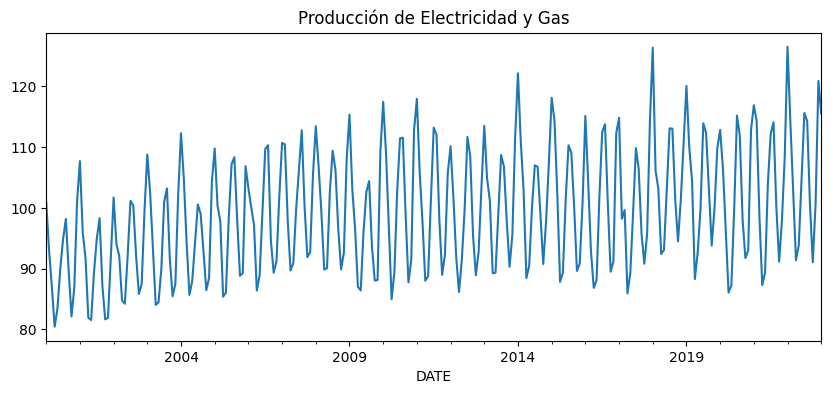

In [ ]:
datos['Producción'].plot(figsize=(10,4), title='Producción de Electricidad y Gas')
plt.show()

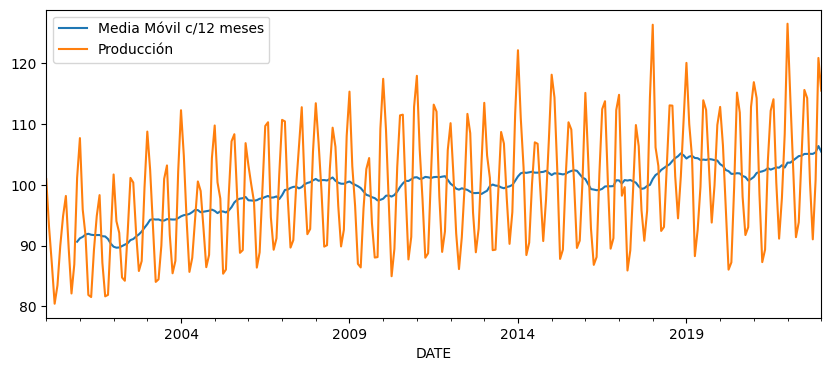

In [ ]:
datos['Producción'].rolling(12).mean().plot(figsize=(10,4),label='Media Móvil c/12 meses')
datos['Producción'].plot()
plt.legend()
plt.show()

La funcion seasonal_decompose() de statsmodels, descompone la serie en tres partes: tendencia, estacionalidad y residuos.

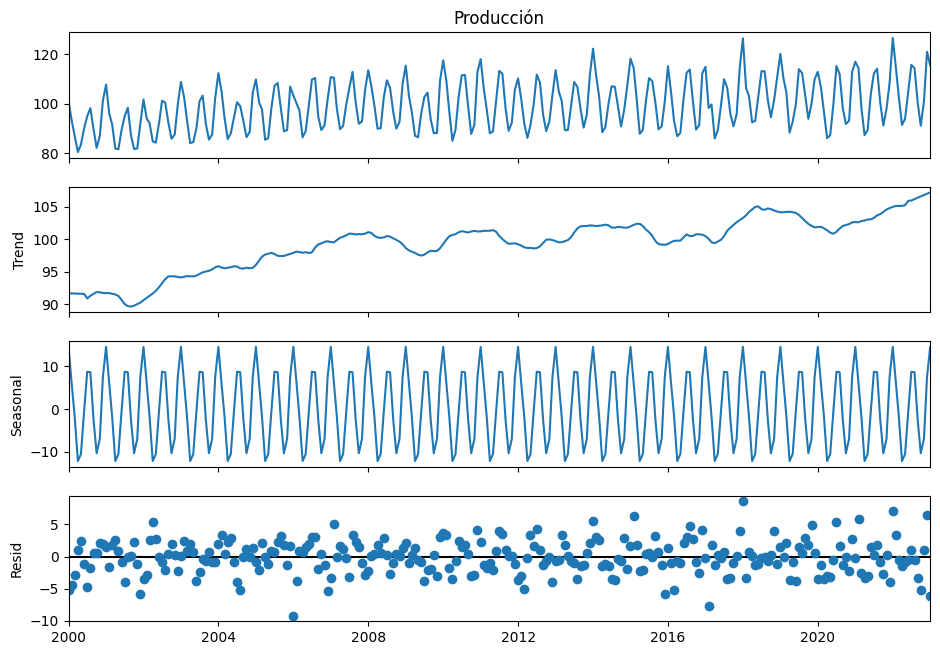

In [ ]:
decomp = seasonal_decompose(datos['Producción']
                            , period=12, extrapolate_trend='freq'
                            )
fig =decomp.plot()
fig.set_size_inches(10,7)

## Estacionariedad de la Serie

Realizamos el **test Dickey-Fuller** en la cual, **la hipótesis nula es que los datos no son estacionarios** (*si p es muy pequeña, rechazaremos la hipotesis nula*)
La hipotesis alternativa es que son estacionarios

In [ ]:
p_value_adfuller(datos['Producción'])

P-value:  0.4533504471596746
No se rechaza la hipóteis nula, los datos no son estacionarios


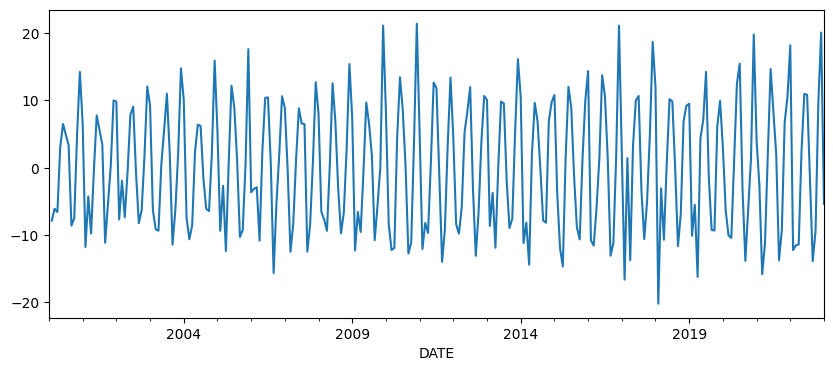

In [ ]:
datos['1a diff']= datos['Producción'] - datos['Producción'].shift(1)
datos['1a diff'].plot(figsize=(10,4))
plt.show()

In [ ]:
p_value_adfuller(datos['1a diff'].dropna())

P-value:  1.0639526450825224e-09
Se rechaza la hipótesis nula, los datos son estacionarios


## Visualización de la ACF y PACF

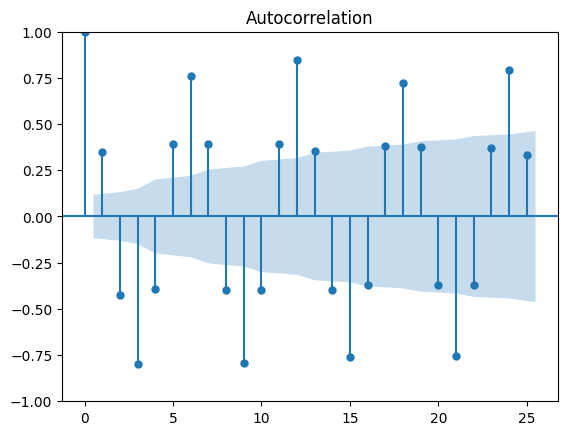

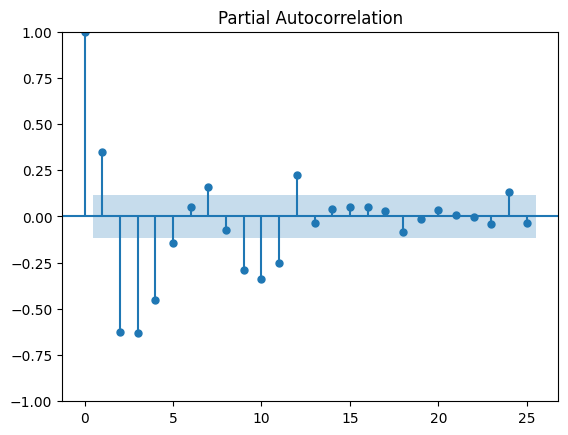

In [ ]:
plot_acf(datos['1a diff'].dropna())
plot_pacf(datos['1a diff'].dropna())
plt.show()

# Construcción del modelo SARIMA



## División de la serie en entrenamiento y prueba

In [ ]:
from datetime import  timedelta
from dateutil.relativedelta import relativedelta

end_month =  datos.index.max()
split_month = end_month + relativedelta(months=-12)
split_month

Timestamp('2022-01-01 00:00:00', freq='MS')

In [ ]:
train = datos.loc[:split_month,'Producción']
test = datos.loc[split_month:,'Producción']

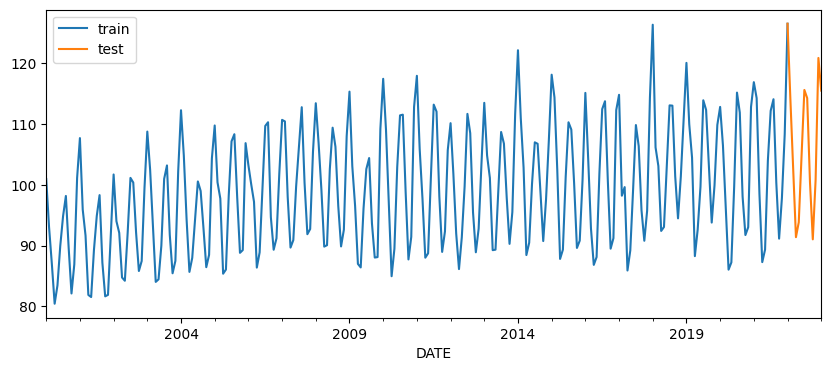

In [ ]:
train.plot(label = 'train', figsize =(10,4))
test.plot(label = 'test', figsize =(10,4))
plt.legend()
plt.show()

## Orden del modelo ARIMA (pdq) y entrenamiento

In [ ]:
p =  q = range(0, 3)
pdq = list(itertools.product(p, [1], q))
pdq

[(0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (1, 1, 0),
 (1, 1, 1),
 (1, 1, 2),
 (2, 1, 0),
 (2, 1, 1),
 (2, 1, 2)]

In [ ]:
p = d =  q = range(0, 3)
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 0, 2, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (0, 1, 2, 12),
 (0, 2, 0, 12),
 (0, 2, 1, 12),
 (0, 2, 2, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 2, 0, 12),
 (1, 2, 1, 12),
 (1, 2, 2, 12),
 (2, 0, 0, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 1, 0, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 2, 0, 12),
 (2, 2, 1, 12),
 (2, 2, 2, 12)]

In [ ]:
aic_modelos = {}
for parametros in pdq:
  for parametros_s in seasonal_pdq:
      modelo = SARIMAX(train,
                       order = parametros,             # p, q, d
                       seasonal_order = parametros_s,  # p, q, d  de la temporalidad
                       enforce_stationarity = False,
                       enforce_invertibility = False   # permite que el polinomio de promedio móvil no sea invertible,
                                                       # de modo que la mayoría de los modelos sean estimables.
                       )
      results = modelo.fit()
      aic_modelos[parametros, parametros_s] = results.aic
      print('ARIMA{} x {} - AIC:{}'.format(parametros, parametros_s, results.aic))

ARIMA(0, 1, 0) x (0, 0, 0, 12) - AIC:1911.9389894338033
ARIMA(0, 1, 0) x (0, 0, 1, 12) - AIC:1648.125312567458
ARIMA(0, 1, 0) x (0, 0, 2, 12) - AIC:1497.6281173862913
ARIMA(0, 1, 0) x (0, 1, 0, 12) - AIC:1419.9459736730503
ARIMA(0, 1, 0) x (0, 1, 1, 12) - AIC:1268.527505708967
ARIMA(0, 1, 0) x (0, 1, 2, 12) - AIC:1209.7075023120194
ARIMA(0, 1, 0) x (0, 2, 0, 12) - AIC:1577.3384109987387
ARIMA(0, 1, 0) x (0, 2, 1, 12) - AIC:1329.481266394319
ARIMA(0, 1, 0) x (0, 2, 2, 12) - AIC:1196.4345818202141
ARIMA(0, 1, 0) x (1, 0, 0, 12) - AIC:1418.9978584339397
ARIMA(0, 1, 0) x (1, 0, 1, 12) - AIC:1324.219296847598
ARIMA(0, 1, 0) x (1, 0, 2, 12) - AIC:1265.5628607917874
ARIMA(0, 1, 0) x (1, 1, 0, 12) - AIC:1340.9461673139335
ARIMA(0, 1, 0) x (1, 1, 1, 12) - AIC:1274.3166899411622
ARIMA(0, 1, 0) x (1, 1, 2, 12) - AIC:1209.0819323951196
ARIMA(0, 1, 0) x (1, 2, 0, 12) - AIC:1439.3975283167251
ARIMA(0, 1, 0) x (1, 2, 1, 12) - AIC:1316.7959381736289
ARIMA(0, 1, 0) x (1, 2, 2, 12) - AIC:1198.4306823113

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 2) x (2, 0, 2, 12) - AIC:1189.6059195931757
ARIMA(1, 1, 2) x (2, 1, 0, 12) - AIC:1180.2625430366618
ARIMA(1, 1, 2) x (2, 1, 1, 12) - AIC:1141.0663182200024
ARIMA(1, 1, 2) x (2, 1, 2, 12) - AIC:1128.5841602284108
ARIMA(1, 1, 2) x (2, 2, 0, 12) - AIC:1261.028499120743
ARIMA(1, 1, 2) x (2, 2, 1, 12) - AIC:1165.4373341412922
ARIMA(1, 1, 2) x (2, 2, 2, 12) - AIC:1131.0645333326388
ARIMA(2, 1, 0) x (0, 0, 0, 12) - AIC:1740.0229582763195
ARIMA(2, 1, 0) x (0, 0, 1, 12) - AIC:1584.2980800580533
ARIMA(2, 1, 0) x (0, 0, 2, 12) - AIC:1468.3372226362453
ARIMA(2, 1, 0) x (0, 1, 0, 12) - AIC:1376.400253065843
ARIMA(2, 1, 0) x (0, 1, 1, 12) - AIC:1238.8749562618277
ARIMA(2, 1, 0) x (0, 1, 2, 12) - AIC:1177.3385894084126
ARIMA(2, 1, 0) x (0, 2, 0, 12) - AIC:1529.8724826190994
ARIMA(2, 1, 0) x (0, 2, 1, 12) - AIC:1290.9745733030518
ARIMA(2, 1, 0) x (0, 2, 2, 12) - AIC:1163.8619784105063
ARIMA(2, 1, 0) x (1, 0, 0, 12) - AIC:1374.8499854849488
ARIMA(2, 1, 0) x (1, 0, 1, 12) - AIC:1283.46366825

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (1, 0, 1, 12) - AIC:1255.2694067572104
ARIMA(2, 1, 2) x (1, 0, 2, 12) - AIC:1198.497837465746
ARIMA(2, 1, 2) x (1, 1, 0, 12) - AIC:1273.3657710875796


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (1, 1, 1, 12) - AIC:1202.1368596869434
ARIMA(2, 1, 2) x (1, 1, 2, 12) - AIC:1141.5246117924517
ARIMA(2, 1, 2) x (1, 2, 0, 12) - AIC:1370.945248448471
ARIMA(2, 1, 2) x (1, 2, 1, 12) - AIC:1251.2488921487611


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (1, 2, 2, 12) - AIC:1133.1724629656067
ARIMA(2, 1, 2) x (2, 0, 0, 12) - AIC:1272.0242765067615


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 0, 1, 12) - AIC:1208.390296530094


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2) x (2, 0, 2, 12) - AIC:1191.6414209921052
ARIMA(2, 1, 2) x (2, 1, 0, 12) - AIC:1175.9769422646973
ARIMA(2, 1, 2) x (2, 1, 1, 12) - AIC:1135.413698804183
ARIMA(2, 1, 2) x (2, 1, 2, 12) - AIC:1130.2817737810692
ARIMA(2, 1, 2) x (2, 2, 0, 12) - AIC:1257.7327011012644
ARIMA(2, 1, 2) x (2, 2, 1, 12) - AIC:1162.2486330129254
ARIMA(2, 1, 2) x (2, 2, 2, 12) - AIC:1132.2950193340807


El criterio de información de Akaike ([AIC](https://es.wikipedia.org/wiki/Criterio_de_informaci%C3%B3n_de_Akaike)) es una medida de la calidad relativa de un modelo estadístico, para un conjunto dado de datos.

Considera la bondad de ajuste del modelo a los datos, pero también la complejidad del modelo (número de parámetros)

AIC ofrece una estimación relativa de la información perdida cuando se utiliza un modelo determinado para representar el proceso que genera los datos

In [ ]:
modelo = min(aic_modelos, key = aic_modelos.get)
print('Modelo: ', modelo )
print('AIC: ',min(aic_modelos.values()))


Modelo:  ((1, 1, 2), (0, 2, 2, 12))
AIC:  1127.8508503635944


In [ ]:
modelo = SARIMAX(train,
                 order = modelo[0],
                 seasonal_order = modelo[1],
                 enforce_stationarity = False,
                 enforce_invertibility = False)
resultados = modelo.fit()
print(resultados.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5397      0.218      2.472      0.013       0.112       0.968
ma.L1         -1.1376      0.245     -4.634      0.000      -1.619      -0.656
ma.L2          0.1848      0.210      0.879      0.379      -0.227       0.597
ma.S.L12      -1.9772    672.381     -0.003      0.998   -1319.821    1315.866
ma.S.L24       1.0000    680.162      0.001      0.999   -1332.094    1334.094
sigma2         7.9999   5441.153      0.001      0.999   -1.07e+04    1.07e+04


# Validación

## Análisis de los residuos del modelo

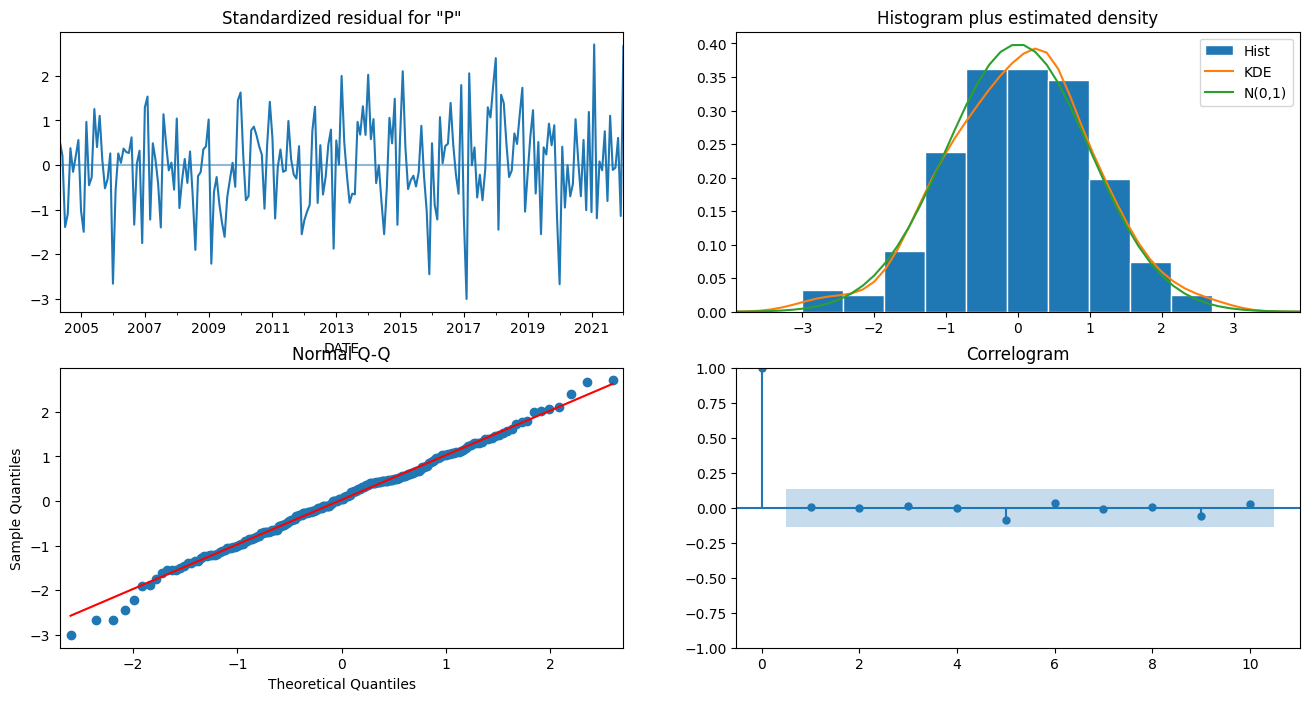

In [ ]:
resultados.plot_diagnostics(figsize = (16,8))
plt.show()

##  Predicción y evaluación del modelo

In [ ]:
pred = resultados.get_prediction(start = split_month,
                                 end =end_month)
pred.predicted_mean

2022-01-01    118.628807
2022-02-01    110.615090
2022-03-01    101.154917
2022-04-01     88.014514
2022-05-01     90.339747
2022-06-01    102.760445
2022-07-01    114.530455
2022-08-01    112.260421
2022-09-01    100.373631
2022-10-01     91.414183
2022-11-01     96.730474
2022-12-01    111.218236
2023-01-01    120.816186
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
#intervalo de confianza
pred_IC = pred.conf_int()
pred_IC

,lower Producción,upper Producción
2022-01-01,112.825812,124.431802
2022-02-01,104.814402,116.415779
2022-03-01,94.908389,107.401444
2022-04-01,81.579707,94.449320
2022-05-01,83.808191,96.871303
2022-06-01,96.169307,109.351584
2022-07-01,107.896421,121.164488
2022-08-01,105.591563,118.929280
2022-09-01,93.674061,107.073201
2022-10-01,84.686082,98.142285


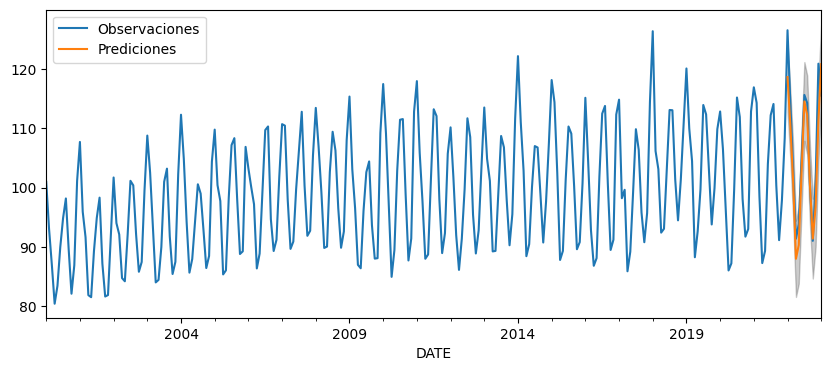

In [ ]:
fig = datos.loc[:,'Producción'].plot(label = 'Observaciones',
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index,
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1],
                 color='k', alpha=.2)
plt.legend()
plt.show()

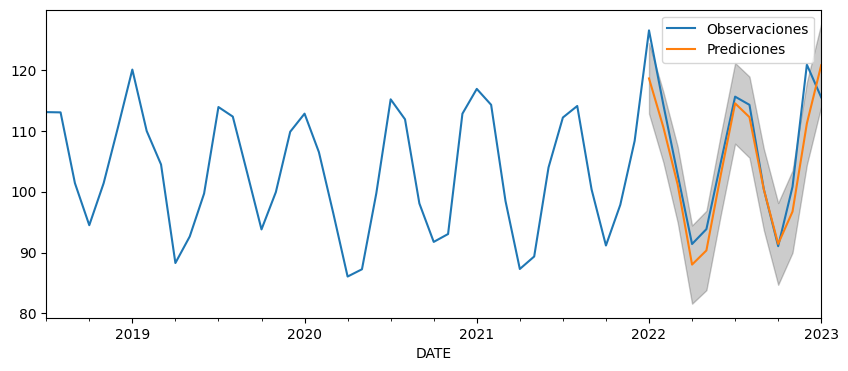

In [ ]:
fig = datos.loc['2018-07-01':,'Producción'].plot(label = 'Observaciones',
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index,
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1],
                 color='k', alpha=.2)
plt.legend()
plt.show()

In [ ]:
y_pred  = pred.predicted_mean
y_real = datos.loc[split_month:end_month,'Producción']
mse = ((y_pred - y_real) ** 2).mean()
print('El error cuadrático medio es {}'.format(round(mse, 2)))
print('La raiz del error cuadrático medio es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio es 19.26
La raiz del error cuadrático medio es 4.39


In [ ]:
datos.head(10)

,Producción,1a diff
DATE,,
2000-01-01,100.9623,NaN
2000-02-01,93.1065,-7.8558
2000-03-01,87.0234,-6.0831
2000-04-01,80.4433,-6.5801
2000-05-01,83.4549,3.0116
2000-06-01,89.9617,6.5068
2000-07-01,94.8591,4.8974
2000-08-01,98.1809,3.3218
2000-09-01,89.5896,-8.5913
